/home/antoine/.local/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


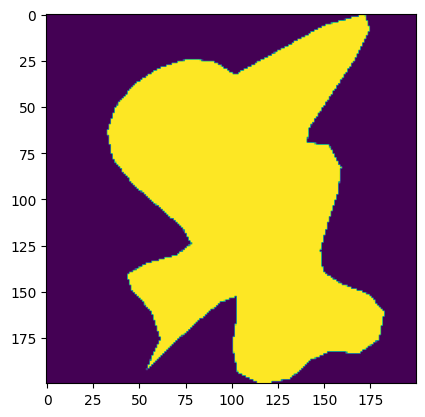

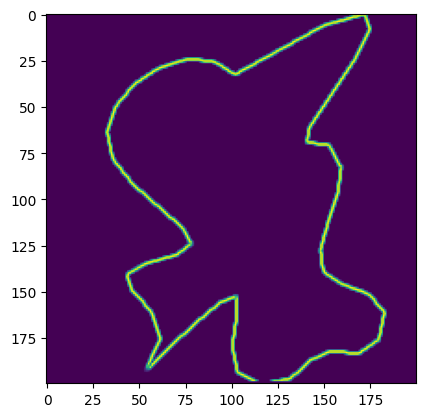

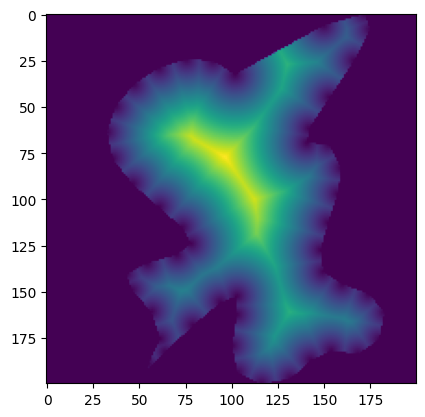

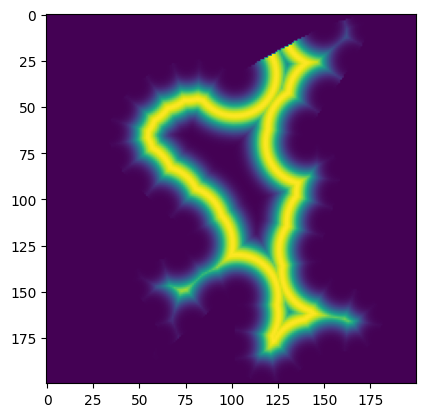

In [1]:
from torch_contour.torch_contour import Contour_to_distance_map,Contour_to_isolines, Contour_to_mask, Draw_contour, Smoothing
import torch
import matplotlib.pyplot as plt

polygons1 = torch.tensor(
    [
        [
            [
                [0.1640, 0.5085],
                [0.1267, 0.4491],
                [0.1228, 0.3772],
                [0.1461, 0.3027],
                [0.1907, 0.2356],
                [0.2503, 0.1857],
                [0.3190, 0.1630],
                [0.3905, 0.1774],
                [0.4595, 0.2317],
                [0.5227, 0.3037],
                [0.5774, 0.3658],
                [0.6208, 0.3905],
                [0.6505, 0.3513],
                [0.6738, 0.2714],
                [0.7029, 0.2152],
                [0.7461, 0.2298],
                [0.8049, 0.2828],
                [0.8776, 0.3064],
                [0.9473, 0.2744],
                [0.9606, 0.2701],
                [0.9138, 0.3192],
                [0.8415, 0.3947],
                [0.7793, 0.4689],
                [0.7627, 0.5137],
                [0.8124, 0.5142],
                [0.8961, 0.5011],
                [0.9696, 0.5158],
                [1.0000, 0.5795],
                [0.9858, 0.6581],
                [0.9355, 0.7131],
                [0.9104, 0.7682],
                [0.9184, 0.8406],
                [0.8799, 0.8974],
                [0.8058, 0.9121],
                [0.7568, 0.8694],
                [0.7305, 0.7982],
                [0.6964, 0.7466],
                [0.6378, 0.7394],
                [0.5639, 0.7597],
                [0.4864, 0.7858],
                [0.4153, 0.7953],
                [0.3524, 0.7609],
                [0.3484, 0.7028],
                [0.3092, 0.7089],
                [0.2255, 0.7632],
                [0.1265, 0.8300],
                [0.0416, 0.8736],
                [0.0000, 0.8584],
                [0.0310, 0.7486],
                [0.1640, 0.5085],
            ]
        ]
    ],
    dtype=torch.float32,
)

width = 200

Mask = Contour_to_mask(width)
Draw = Draw_contour(width)
Dmap = Contour_to_distance_map(width)
Iso = Contour_to_isolines(width, isolines=[0.1, 0.5, 1])
Smoother = Smoothing(sigma=1)

mask = Mask(polygons1).cpu().detach().numpy()[0, 0]
draw = Draw(polygons1).cpu().detach().numpy()[0, 0]
distance_map = Dmap(polygons1).cpu().detach().numpy()[0, 0]
isolines = Iso(polygons1).cpu().detach().numpy()[0, 0]

plt.imshow(mask)
plt.show()
plt.imshow(draw)
plt.show()
plt.imshow(distance_map)
plt.show()
plt.imshow(isolines[1])
plt.show()